# Using a GAN to generate fake handwritten digits 

### Loading up the MNIST dataset

In [131]:
# importing the necessary libraries

import numpy as np
import os
import torch 
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
# defining the image size and the batch size
image_size = 28
batch_size = 69

In [133]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [134]:
# creating the training and testing datasets
train_ds = MNIST(root = "data/", train = True, transform = T.ToTensor(), download = True)
test_ds = MNIST(root = "data/", train = False, transform = T.ToTensor())


Label: 5


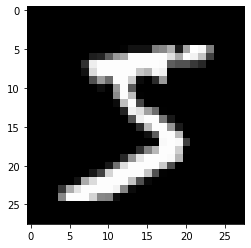

In [135]:
# looking at some of the images from the dataset
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [136]:
# printing out the shape of these images and labels
print(train_ds[0][0].shape)
# so its an image of pixel size 28x28

torch.Size([1, 28, 28])


### Defining the device data loader class

In [137]:
def get_default_device():
    # Pick gpu if available else cpu
    if torch.cuda.is_available():
        return torch.device("cuda")
    
    else:
        return torch.device("cpu")
    

def to_device(data, device):
    # move data to the gpu
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    # Wraps a data loader to move the data to the device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        # number of batches
        return len(self.dl)

In [138]:
device = get_default_device()
print(device)

cuda


In [139]:
# creating the data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [140]:
# transferring the dataloader to the gpu
train_dl = DeviceDataLoader(train_dl, device)

## Defining the Discriminator Network

In [141]:
discriminator = nn.Sequential(
    # input : 1 x 28 x 28
    # instead of max pooling, we are using stride = 2 as it gives better results for gans
    nn.Conv2d(1, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(16),
    # leaky relu gives alpha x input for input < 0(alpha = 0.2 here)
    nn.LeakyReLU(0.2, inplace = True),
    
    # input : 16 x 14 x 14
    nn.Conv2d(16, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    
    # input : 64 x 7 x 7
    nn.Conv2d(64, 256, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    
    # input : 256 x 4 x 4
    nn.Conv2d(256, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    # input : 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid())

In [142]:
# lets move the discriminator to the gpu
discriminator = to_device(discriminator, device)

## Generator

In [143]:
# generator performs deconvolution in order to transform a random latent tensor into an image 
# as batch size = 69 we will pass this as the batch size here too

In [144]:
latent_size = 69

generator = nn.Sequential(
    # initially it is a random tensor of 69 x 1 x 1
    nn.ConvTranspose2d(latent_size, 256, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    # input : 256 x 4 x 4
    nn.ConvTranspose2d(256, 64, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    # input : 64 x 7 x 7
    nn.ConvTranspose2d(64, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    
    # input : 16 x 14 x 14
    nn.ConvTranspose2d(16, 1, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh(),
    # output : 1 x 28 x 28
)

In [145]:
# generating random images
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)

torch.Size([69, 1, 28, 28])


In [146]:
# lets move the generator to the gpu
generator = to_device(generator, device)

## Discriminator Training

In [147]:
def train_discriminator(real_images, opt_d):
    
    # clearing any left over gradients in the discriminator
    opt_d.zero_grad()
    
    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # trying to fool the discriminator by passing fake images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Training Generator

In [148]:
def train_generator(opt_g):
    
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [149]:
from torchvision.utils import save_image

In [150]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [151]:
# save samples
def save_samples(index, latent_tensors, show=True):
    
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [152]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


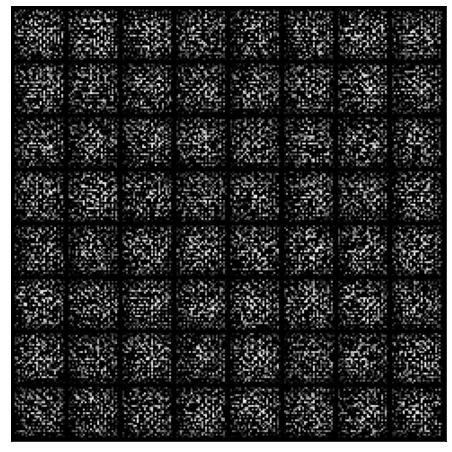

In [153]:
save_samples(0, fixed_latent)

## Full Training Loop

In [154]:
def fit(epochs, lr, start_idx = 1):
    
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [155]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 3.4126, loss_d: 0.0882, real_score: 0.9669, fake_score: 0.0519
Saving generated-images-0001.png



Epoch [2/25], loss_g: 4.3235, loss_d: 0.0245, real_score: 0.9850, fake_score: 0.0091
Saving generated-images-0002.png



Epoch [3/25], loss_g: 0.5754, loss_d: 7.7482, real_score: 0.9998, fake_score: 0.9372
Saving generated-images-0003.png



Epoch [4/25], loss_g: 4.6891, loss_d: 0.0512, real_score: 0.9898, fake_score: 0.0392
Saving generated-images-0004.png



Epoch [5/25], loss_g: 4.3599, loss_d: 0.0576, real_score: 0.9642, fake_score: 0.0199
Saving generated-images-0005.png



Epoch [6/25], loss_g: 4.0367, loss_d: 0.0472, real_score: 0.9752, fake_score: 0.0211
Saving generated-images-0006.png



Epoch [7/25], loss_g: 4.9226, loss_d: 0.0223, real_score: 0.9907, fake_score: 0.0127
Saving generated-images-0007.png



Epoch [8/25], loss_g: 3.7689, loss_d: 0.2191, real_score: 0.8418, fake_score: 0.0084
Saving generated-images-0008.png



Epoch [9/25], loss_g: 4.2075, loss_d: 0.0914, real_score: 0.9947, fake_score: 0.0776
Saving generated-images-0009.png



Epoch [10/25], loss_g: 3.1412, loss_d: 0.1694, real_score: 0.8660, fake_score: 0.0056
Saving generated-images-0010.png



Epoch [11/25], loss_g: 3.4284, loss_d: 0.1691, real_score: 0.9507, fake_score: 0.0988
Saving generated-images-0011.png



Epoch [12/25], loss_g: 4.8136, loss_d: 0.1067, real_score: 0.9788, fake_score: 0.0751
Saving generated-images-0012.png



Epoch [13/25], loss_g: 4.9458, loss_d: 0.0570, real_score: 0.9642, fake_score: 0.0183
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.0865, loss_d: 0.1425, real_score: 0.9500, fake_score: 0.0798
Saving generated-images-0014.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0015.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
# plotting the losses against epochs
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
# plotting the scores against the epochs
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');